In [1]:
import numpy as np
import pandas as pd
import gc
import time
import pickle
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
#warnings.simplefilter(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb


# Merge des differents jeux de donnees
En utilisant le kernel kaggle

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    #test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}".format(len(df)))
    #df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
         # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    #les seules valeurs positives dans "Days_Employed" sont les valeurs 365.243
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    #del test_df
    gc.collect()
    return df

In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [6]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [7]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [8]:
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [9]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [10]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [11]:
df=main()

Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 27s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 51s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 30s
Installments payments df shape: (339587, 26)
Process installments payments - done in 66s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 72s


In [12]:
df.shape

(307507, 797)

In [13]:
df.to_csv('all_data_clean.csv', index=False)

In [2]:
df=pd.read_csv('all_data_clean.csv')

In [3]:
df.shape

(307507, 797)

# Exploration du dataset final

## 1- Remplacer les valeur inf par Nan

In [4]:
np.isinf(df).sum().sort_values(ascending=False)

INSTAL_PAYMENT_PERC_MAX                      18
REFUSED_APP_CREDIT_PERC_MAX                   1
PREV_APP_CREDIT_PERC_MAX                      1
SK_ID_CURR                                    0
PREV_PRODUCT_COMBINATION_Card Street_MEAN     0
                                             ..
BURO_AMT_ANNUITY_MAX                          0
BURO_AMT_ANNUITY_MEAN                         0
BURO_CNT_CREDIT_PROLONG_SUM                   0
BURO_MONTHS_BALANCE_MIN_MIN                   0
CC_COUNT                                      0
Length: 797, dtype: int64

In [5]:
pb_col=np.isinf(df).sum().sort_values(ascending=False)
pb_col=pb_col[pb_col>0].index
df[pb_col] =df[pb_col].replace(np.inf, np.nan)

## 2 - Explorer les valeurs Nan

In [6]:
temp=df.isna().mean().sort_values(ascending=False)

temp

REFUSED_AMT_DOWN_PAYMENT_MAX      0.853116
REFUSED_AMT_DOWN_PAYMENT_MEAN     0.853116
REFUSED_AMT_DOWN_PAYMENT_MIN      0.853116
REFUSED_RATE_DOWN_PAYMENT_MEAN    0.853116
REFUSED_RATE_DOWN_PAYMENT_MAX     0.853116
                                    ...   
ORGANIZATION_TYPE_Emergency       0.000000
ORGANIZATION_TYPE_Electricity     0.000000
ORGANIZATION_TYPE_Culture         0.000000
ORGANIZATION_TYPE_Construction    0.000000
SK_ID_CURR                        0.000000
Length: 797, dtype: float64

In [7]:
temp.describe()

count    797.000000
mean       0.259274
std        0.304385
min        0.000000
25%        0.051602
50%        0.056678
75%        0.673861
max        0.853116
dtype: float64

In [8]:
temp.describe(percentiles=[0.60,0.65, 0.70, 0.80, 0.90])

count    797.000000
mean       0.259274
std        0.304385
min        0.000000
50%        0.056678
60%        0.143151
65%        0.251526
70%        0.489773
80%        0.714357
90%        0.717389
max        0.853116
dtype: float64

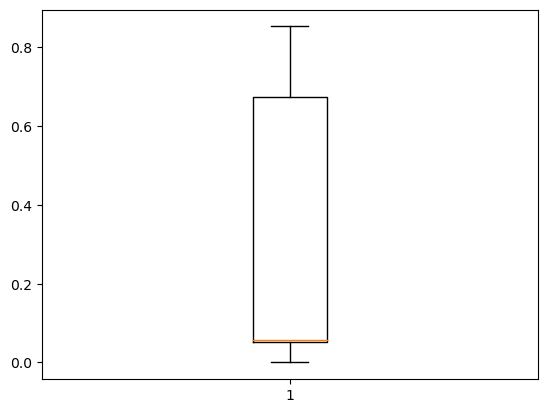

In [9]:
plt.boxplot(temp)
plt.show()

In [10]:
temp=temp[temp>0.5]
temp.describe()

count    236.000000
mean       0.708699
std        0.071000
min        0.501937
25%        0.698722
50%        0.717389
75%        0.719444
max        0.853116
dtype: float64

### On enleve les variables avec plus de 50% de valeurs manquantes

In [11]:
df=df.drop(columns=temp.index)

In [12]:
df.shape

(307507, 561)

## 3- Explorer le jeu de donnee 

In [13]:
df.dtypes.value_counts()

float64    385
int64      176
dtype: int64

In [14]:
data_type=df.dtypes

cont_var=data_type[data_type=='float64'].index
int_var=data_type[data_type=='int64'].index #contient des variable booleene et des variables quantitatives tel DAYS_Birth

### Exploration des valeurs manquantes des variables qualititatives
Pas de valeurs manquantes dans les variables qualititatives restantes apres premier netoyage

In [16]:
df[int_var].isna().sum().sort_values(ascending=False).head(5)

SK_ID_CURR                      0
TARGET                          0
ORGANIZATION_TYPE_Emergency     0
ORGANIZATION_TYPE_Government    0
ORGANIZATION_TYPE_Hotel         0
dtype: int64

### Exploration des valeurs manquantes pour les variables quantitatives

In [18]:
df[cont_var].isna().sum().sort_values(ascending=False)

FLOORSMAX_MEDI                  153019
FLOORSMAX_MODE                  153019
FLOORSMAX_AVG                   153019
YEARS_BEGINEXPLUATATION_MODE    150006
YEARS_BEGINEXPLUATATION_AVG     150006
                                 ...  
INCOME_CREDIT_PERC                   0
AMT_CREDIT                           0
DAYS_REGISTRATION                    0
REGION_POPULATION_RELATIVE           0
AMT_INCOME_TOTAL                     0
Length: 385, dtype: int64

### Exploration de la variable cible TARGET
les 2 classes sont tres desequilibrees

In [19]:
df['TARGET'].value_counts(normalize=True)

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

In [20]:
df['TARGET'].value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

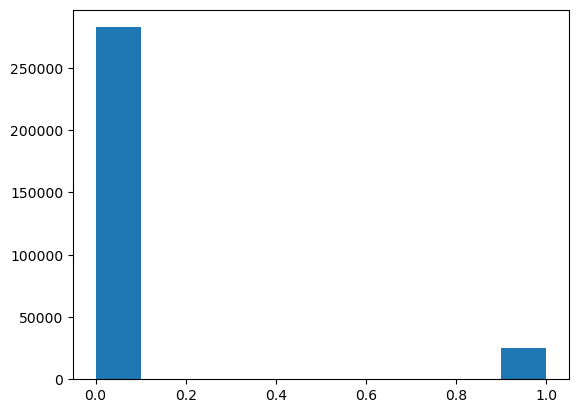

In [21]:
plt.hist(df['TARGET'])
plt.show()

## 4- Enlever les variables a variances nulle 

In [28]:
temp=df.describe().transpose()
temp[temp['std']==0]

,count,mean,std,min,25%,50%,75%,max
BURO_CREDIT_ACTIVE_nan_MEAN,263487.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BURO_CREDIT_CURRENCY_nan_MEAN,263487.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BURO_CREDIT_TYPE_nan_MEAN,263487.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_NAME_CONTRACT_TYPE_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_NAME_CONTRACT_STATUS_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_NAME_PAYMENT_TYPE_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_CODE_REJECT_REASON_nan_MEAN,291053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
to_del=temp[temp['std']==0].index
df=df.drop(columns=to_del)
df.shape

(307507, 542)

In [31]:
df.to_csv('df_clean_withNa.csv', index=False)

### Exploration des variables quasi constantes
Nous regardons la distribution des variables et donnant notre attention aux variables nulles sur prestques toutes les valeurs. Pour cela on calcul la difference entre la valeur minimal et le quantile 0.99

In [26]:
df=pd.read_csv('df_clean_withNa.csv')

In [27]:
data_type=df.dtypes

cont_var=data_type[data_type=='float64'].index
int_var=data_type[data_type=='int64'].index #contient des variable booleene et des variables quantitatives tel DAYS_Birth

In [28]:
dist=pd.DataFrame()
dist['min']=df[cont_var].min()
dist[0.99]=df[cont_var].quantile(0.99)
dist['IQR']=dist[0.99]-dist['min']
temp=dist[dist['IQR']==0].index

In [31]:
len(temp)

72

In [32]:
#On verifie que la quasi constance est la meme pour les 2 groupes de labels 
#(le quantile 0.99 est nulle pour la classe minoritaire)
to_del=df.groupby(by='TARGET')[temp].quantile(0.99).transpose()[df.groupby(by='TARGET')[temp].quantile(0.99).transpose()[1]==0]

In [35]:
df=df.drop(columns=to_del.index)
df.shape

(307507, 472)

In [36]:
data_type=df.dtypes
#cat_var=data_type[data_type=='uint8'].index # valeurs generer par one hot encoder
cont_var=data_type[data_type=='float64'].index
#int_var=data_type[data_type=='int64'].index #contient des variable booleene et des variables quantitatives tel DAYS_Birth

### On explore les variables constantes a 95% dansles 2 categories label

In [39]:
dist=pd.DataFrame()
dist['min']=df[cont_var].min()
dist[0.95]=df[cont_var].quantile(0.95)
dist['IQR']=dist[0.95]-dist['min']
temp=dist[dist['IQR']==0].index
len(temp)

31

In [40]:
to_del=df.groupby(by='TARGET')[temp].quantile(0.95).transpose()[df.groupby(by='TARGET')[temp].quantile(0.95).transpose()[1]==0]

In [41]:
df=df.drop(columns=to_del.index)
df.shape

(307507, 444)

## 5- Remplacement des valeurs Nan

In [51]:
data_type=df.dtypes
cont_var=data_type[data_type=='float64'].index

### Pour les variables de type Float (numeriques)
On remplace les valeurs manquantes par la mediane

In [52]:
df[cont_var].isna().mean().describe()

count    268.000000
mean       0.108325
std        0.107722
min        0.000000
25%        0.053508
50%        0.053508
75%        0.143151
max        0.497611
dtype: float64

In [56]:
temp=df.isna().mean().sort_values(ascending=False)
temp=temp[temp>0]
temp

FLOORSMAX_AVG                       0.497611
FLOORSMAX_MODE                      0.497611
FLOORSMAX_MEDI                      0.497611
YEARS_BEGINEXPLUATATION_AVG         0.487813
YEARS_BEGINEXPLUATATION_MODE        0.487813
YEARS_BEGINEXPLUATATION_MEDI        0.487813
TOTALAREA_MODE                      0.482688
CLOSED_DAYS_CREDIT_VAR              0.425522
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN    0.402023
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN    0.386277
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN    0.352964
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN     0.328438
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX      0.328438
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN     0.322998
ACTIVE_DAYS_CREDIT_ENDDATE_MIN      0.322998
ACTIVE_DAYS_CREDIT_ENDDATE_MAX      0.322998
APPROVED_APP_CREDIT_PERC_VAR        0.306549
dtype: float64

In [62]:
for col in temp.index:
    df[col]=df[col].fillna(df[col].median())

In [63]:
df.isna().sum().sort_values(ascending=False)

SK_ID_CURR                                        0
PREV_CNT_PAYMENT_MEAN                             0
PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN    0
PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN      0
PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN     0
                                                 ..
ORGANIZATION_TYPE_Industry: type 12               0
ORGANIZATION_TYPE_Industry: type 11               0
ORGANIZATION_TYPE_Industry: type 10               0
ORGANIZATION_TYPE_Industry: type 1                0
INSTAL_COUNT                                      0
Length: 444, dtype: int64

In [64]:
df.to_csv('df_clean_withoutNa.csv', index=False)

### Calcul du rapport des classes
On voit que le poids de la classe negative (classe 0) est 11 fois plus grand que celui de la classe positive (calsse 1)

In [65]:
X=df.drop(columns=['TARGET'])
y=df[['TARGET']]

In [66]:
y.value_counts()

TARGET
0         282682
1          24825
dtype: int64

In [67]:
scale_pos_weight=y.value_counts()[0]/y.value_counts()[1]
scale_pos_weight

11.386988922457201

## 6- Diviser le dataset en train et test set

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Le rapport des classes est maintenu dans les train et test sets

In [69]:
print('scale_pos_weight train set: ', y_train.value_counts()[0]/y_train.value_counts()[1])
print('scale_pos_weight test set: ', y_test.value_counts()[0]/y_test.value_counts()[1])


scale_pos_weight train set:  11.370399279495647
scale_pos_weight test set:  11.420807833537332


In [70]:
id_train=X_train[['SK_ID_CURR']]
X_train=X_train.drop(columns=['SK_ID_CURR'])
id_test=X_test[['SK_ID_CURR']]
X_test=X_test.drop(columns=['SK_ID_CURR'])

In [71]:
id_train.to_csv('id_train.csv', index=False)
id_test.to_csv('id_test.csv', index=False)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Recherche des hyperparametres

In [2]:
X_train=pd.read_csv('X_train.csv')
X_test=pd.read_csv('X_test.csv')
y_train=pd.read_csv('y_train.csv')
y_test=pd.read_csv('y_test.csv')

In [3]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## 1- Algorithme d'optimisation personnalise

### Custom metric
La fonction de score personalisee est basee sur le rapport des classe, on donne aux faux negatifs 11 fois plus de poids qu'aux faux positifs

In [6]:
def custom_metric(y_true, y_pred):
    m=confusion_matrix(y_true, y_pred)
    return(m[0,1]+11*m[1,0])

### Algorithme d'optimisation du seuil
On utilisera cette fonction de score pour optimiser les resultat du modele et sela en effectuant un erecherche recursive sur le seuil qui minimisera ce score

In [14]:
def get_thresh(model):
    best_th=None
    best_score=np.inf
    for thresh in np.linspace(0,1,100):
        y_prob=model.predict_proba(X_test)
        y_pred=(y_prob[:,1]>thresh).astype('int')
        score=custom_metric(y_test, y_pred)
        if score<best_score:
            best_score=score
            best_th=thresh
    return(best_score, best_th)

### Score personalise
On definit d'abord notre custom score a l'aide du make_scorer. Nous utiliserons ensuite ce score personalise dans la fonction a minimiser de hyperopt

In [126]:
from sklearn.metrics import  make_scorer
custom_score = make_scorer(custom_metric)

## 2- Dummy classifier 
On commence par utiiser le dummy classifier pour avoir un seuil de comparaison des performance. On utilise la strategie stratified 

In [4]:
dum_clf=DummyClassifier(strategy='stratified')
dum_clf.fit(X_train, y_train)
y_pred=dum_clf.predict(X_test)

In [5]:
confusion_matrix(y_test, y_pred)

array([[85826,  7482],
       [ 7499,   671]], dtype=int64)

In [8]:
custom_metric(y_test, y_pred)

89971

In [9]:
roc_auc_score(y_test, y_pred)

0.5009718462313175

## 3- Logistic Regression

In [18]:
clf=LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [19]:
confusion_matrix(y_test, y_pred)

array([[74960, 18348],
       [ 5601,  2569]], dtype=int64)

In [20]:
print('Custom metric score est : ', custom_metric(y_test, y_pred))
print('roc auc score est :', roc_auc_score(y_test, y_pred))

Custom metric score est :  79959
roc auc score est : 0.5589019983514671


In [21]:
score, thresh=get_thresh(clf)
print('best score ', score)
print('best thresh ', thresh)

best score  75580
best thresh  0.4747474747474748


In [22]:
y_prob=clf.predict_proba(X_test)
y_pred=(y_prob[:,1]>thresh).astype('int')
confusion_matrix(y_test, y_pred)

array([[46394, 46914],
       [ 2606,  5564]], dtype=int64)

### Remarque :
Une classification en utilisant la regression logistique donne des meilluers resultats en ajoutant l'option **class_weight=balanced** cependant les resultats ne sont pas tres satisfaisant. Nous avons choisi de ne pas faire une recherche d'hyperparametre pour la regression logistique. 

## 4- Recherche avec hyperopt

In [5]:
from hyperopt import fmin, hp, tpe, space_eval, STATUS_OK
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
skf=StratifiedKFold(n_splits=3)
features=X_train.columns
X_train=X_train.values

On utilise hyperopt pour la recherche d'hyperparametre, notre recherche utilisera l'algorithme de recherche Bayseeene tpe.suggest pour la minimisation de la fontion de perte. Pour la fonction de perte nous avons travailler sur 2 fonction de pertes differentes en comparant les resultats
* Fonction de perte basee sur le negatif du roc-auc
* Fonction de perte personalisee basee sur une ponderation des faux positifs et faux negatifs 

Nous avons egalement utilise StratifiedKfold(n_split=3) pour la cross-validation. Le score de la fonction etant la moyenne des resultats sur les 3 folds

On fait une recherhce d'hyperparametres pour les trois classifieurs suivants:
* BalancedRandomForest classifier
* Random forest classifier
* LightGbm classifier

### 4.1- Balanced Random forest classifier 
Classificateur de la librairie imblearn, random forest classifier avec methode de resampling embedded pour prendre en compte les datasets non-equilibrees.

### Definition de l'espace de recherche des hyperparametres

In [152]:
brf_space={'n_estimators':hp.randint('n_estimators',200,1000),
            'max_depth': hp.randint('max_depth',10,200),           
            'min_samples_split':hp.uniform('min_samples_split',0,1),   
            'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
            'criterion':hp.choice('criterion',['gini','entropy']),
            'sampling_strategy' : hp.choice('sampling_strategy',['auto', 'all']),
            'max_features':hp.choice('max_features',['sqrt', 'log2']),
            'class_weight' :hp.choice('class_weight',['balanced','balanced_subsample', None])}

### A- Recherche d'hyperparametre par score roc-auc

### Definition de la fonction a minimiser

In [142]:
def objective(params):
    
    model = BalancedRandomForestClassifier( random_state=42, **params )
   
    score = -cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}

### Lancement des recherches 

In [98]:
best_params = fmin(
  fn=objective,
  space=brf_space,
  algo=tpe.suggest,
  max_evals=50)

100%|██████████| 50/50 [2:41:47<00:00, 194.14s/trial, best loss: -0.7487155217889456]  


### Meilleur model pour BalancedRandomForestClassifier
Pour le meilleur modele on fait un fit sur la train test et on regarde les score du test set en calculant
* La matrice de confusion
* le seuil optimal et le score personalise  apres optimisation en utilisant l'algorithme d'optimisation et le costum metric


#### Matrice de confusion avant recherche du seuil optimal

In [108]:
best=space_eval(brf_space, best_params)
model  = BalancedRandomForestClassifier( random_state=42, **best )
y_r=y_train.values
model.fit(X_train, y_r)
y_pred=model.predict(X_test.values)
confusion_matrix(y_test, y_pred)

array([[63972, 29336],
       [ 2564,  5606]], dtype=int64)

In [152]:
pickle.dump((model),open('model_BRF.pkl','wb'))

### Optimisation du custom_metric en variant le seuil de decision

In [57]:
best_score, best_th=get_thresh(model)
best_score

57471

In [58]:
best_th

0.5050505050505051

In [59]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[65295, 28013],
       [ 2678,  5492]], dtype=int64)

### B- Recherche des hyperparametres en utilisant le score personalisee

### Definition de la fonction de score et lancement des recherches

In [153]:
def objective(params):
    
    model  = BalancedRandomForestClassifier( random_state=42, **params )
    
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring=custom_score, n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}

best_params = fmin(
  fn=objective,
  space=brf_space,
  algo=tpe.suggest,
  max_evals=50)

100%|██████████| 50/50 [6:55:02<00:00, 498.05s/trial, best loss: 39950.0]             


### Meilleur model pour BalancedRandomForestClassifier


In [154]:
model  = BalancedRandomForestClassifier( random_state=42, **space_eval(brf_space, best_params) )
pickle.dump((model),open('model_BRF_custom.pkl','wb'))

In [12]:
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
pickle.dump((model),open('model_BRF_custom.pkl','wb'))
print(confusion_matrix(y_test, y_pred))
print('score avant optimisation', custom_metric(y_test, y_pred))

[[63720 29588]
 [ 2668  5502]]
score avant optimisation 58936


#### Execution de l'algorithme de recherche du meilleur seuil

In [156]:
best_score, best_th=get_thresh(model)
print('best score', best_score)
print('best threshold', best_th)

best score 58863
best threshold 0.5050505050505051


In [157]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[65179, 28129],
       [ 2794,  5376]], dtype=int64)

### Conclusion
On voit que pour ce classifieur les resulats pour les 2 fonction de score sont assez proche et l'algorithme d'optimisation du score ne change que tres sensiblement le seuil de decision. Cela est du au fait que ce classifier optimise deja les resultas pour les classes desequilibree. Nous rechercherons cependant les resulats pour les classifieurs plus classiques pour pouvoir comparer les performances. 

### 4.2- Random Forest Classifier
### Definition de l'espace de recherche de parametres

In [13]:
rfc_space={'n_estimators':hp.randint('n_estimators',200,1000),
              
              'max_depth': hp.randint('max_depth',10,200),           
            
            'min_samples_split':hp.uniform('min_samples_split',0,1),   
             'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
              
               'criterion':hp.choice('criterion',['gini','entropy']),
                
           'max_features':hp.choice('max_features',['sqrt', 'log2']),
             'class_weight' :hp.choice('class_weight',[None, 'balanced','balanced_subsample'])}

### A- Recherches des hyperparametres avec roc-auc en variant class-weight

In [14]:
def objective(params):
    
    model = RandomForestClassifier(**params, random_state=42)
   
    score = -cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}
best_params = fmin(
  fn=objective,
  space=rfc_space,
  algo=tpe.suggest,
  max_evals=50)

100%|██████████| 50/50 [5:44:01<00:00, 412.84s/trial, best loss: -0.7388966552321635]  


### Meilleur modele pour RandomForestClassifier

In [15]:
best=space_eval(rfc_space, best_params)
model = RandomForestClassifier(**best, random_state=42)


In [16]:
best

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 154,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 0.003715668215662604,
 'n_estimators': 591}

In [23]:
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
pickle.dump(model, open('rfc_model.pkl', 'wb'))

In [24]:
confusion_matrix(y_test, y_pred)

array([[93308,     0],
       [ 8170,     0]], dtype=int64)

Ce modele predit correctement toutes les instances de la classe 0 mais aucun de la classe 1. On essaie d'ameliorer les performance en variant le seuil de decision pour minimiser notre score personalise

### Optimisation du seuil par custom metric 

In [27]:
best_score, best_th=get_thresh(model)

In [35]:
best_score, best_th=get_thresh(model)
pickle.dump((model, best_th), open('rfc_model_best_th.pkl', 'wb'))

In [30]:
best_th

0.09090909090909091

In [34]:
best_score

58949

In [32]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[65192, 28116],
       [ 2803,  5367]], dtype=int64)

Les performances sont maitenent nettement meilleur en ce qui concerne la prediction de la classe 1 mais le seuil optimal est assez petit. Ce modele peut etre tres sensibles a la prediction des clients eligible au credit.

On essaie de garder la fonction de score roc-auc mais ajouter une couche de resampling en utilisant Smote afin de reequilibrer le jeu de donnnees

### B - Recherche des hyperparametres avec smote
Afin de ne pas compromettre les resultatt du set de validation dans la validation croisee, on utilisera le pipeline de la librairie imblearn 

In [36]:
smote=SMOTE()
def objective(params):
    
    rfc = RandomForestClassifier(**params, random_state=42)
    model= Pipeline(steps = [('sample', smote),
                      ('clf',rfc)])
    score = -cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}
best_params = fmin(
  fn=objective,
  space=rfc_space,
  algo=tpe.suggest,
  max_evals=50)


100%|██████████| 50/50 [12:59:50<00:00, 935.81s/trial, best loss: -0.6978503531151093]   


In [37]:
rfc = RandomForestClassifier(**space_eval(rfc_space, best_params), random_state=42)
model= Pipeline(steps = [('sample', smote),
                      ('clf',rfc)])


In [40]:
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
pickle.dump(model, open('rfc_model_smote.pkl', 'wb'))
confusion_matrix(y_test, y_pred)

array([[89610,  3698],
       [ 7070,  1100]], dtype=int64)

Le resampling ameliore un peu les resultats mais les predictions de la classe 1 ne sont toujours pas tres satisfaisant. On fait une recherche du seuil optimal qui minimise le score personalisee

### Optimisation du seuil par custom metric 

In [41]:
best_score, best_th=get_thresh(model)

In [42]:
best_score

65346

In [43]:
best_th

0.30303030303030304

In [44]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[59851, 33457],
       [ 2899,  5271]], dtype=int64)

In [45]:
pickle.dump((model,best_th), open('rfc_model_smote_best_th.pkl', 'wb'))

Les resultas sont un peu plus positive, on voit qu'un seuil de decision a 0.30 donne des resultats nettement meilleurs. Nous essairons cependant de voir si une recherche basee sur la minimisation de notre score personalisee peut avoir de meilleurs performances. Nous effectuerons cette recherche sans resampling

### C- Recherche d'hyperparametre par custom metric

In [146]:
def objective(params):
    
    model = RandomForestClassifier(**params, random_state=42)
   
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring=custom_score, n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}
best_params = fmin(
  fn=objective,
  space=rfc_space,
  algo=tpe.suggest,
  max_evals=50)

100%|██████████| 50/50 [9:34:08<00:00, 688.97s/trial, best loss: 40894.0]             


In [147]:
best=space_eval(rfc_space, best_params)
model = RandomForestClassifier(**best, random_state=42)



In [14]:
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
pickle.dump(model, open('rfc_model_custom.pkl', 'wb'))
print(confusion_matrix(y_test, y_pred))
print('Score avant optimisation', custom_metric(y_test, y_pred))

[[65560 27748]
 [ 2941  5229]]
Score avant optimisation 60099


In [149]:
best_score, best_th=get_thresh(model)
pickle.dump((model, best_th), open('rfc_model_custom_best_th.pkl', 'wb'))

In [150]:
print('best score', best_score)
print('best threshhold', best_th)

best score 60001
best threshhold 0.494949494949495


In [151]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[63766, 29542],
       [ 2769,  5401]], dtype=int64)

Les resulats ne sont pas tres differentes des resulats du score roc-auc, cependant avec notre score personalise, le seuil de decision est deja satisfaisant et l'algorithme d'optimisation n'ameliore pas les performances

### 4.3- LightGbm Classifier
### Definition de l'espace de recherche des parametres

In [124]:
lgbm_space={    
        'n_estimators': hp.randint('n_estimators',200, 1000),
        'learning_rate': hp.uniform('learning_rate', 0, 0.3),
        'subsample': hp.uniform('subsample',0.4,1), 
        'colsample_bytree': hp.uniform('colsample_bytree',0.4,1),
        'reg_lambda': hp.loguniform('reg_lambda',np.log(1e-4),np.log(10)),
        'reg_alpha': hp.loguniform('reg_alpha',np.log(1e-4),np.log(10)),
        'class_weight' :hp.choice('class_weight',['balanced', None]),
        'scale_pos_weight':hp.choice('scale_pos_weight', [1, int(scale_pos_weight)])
    
}

### A- Recherche des hyperparametre en utilisant le score roc-auc sans resampling

### Definition de la fonction de score et lancement de recherche

In [16]:
def objective(params): 
    model =  lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 1, random_state=42, **params)
        
    score = -cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}

best_params = fmin(
  fn=objective,
  space=lgbm_space,
  algo=tpe.suggest,
  max_evals=50)

100%|████████████████████████████████████████████| 50/50 [4:13:05<00:00, 303.72s/trial, best loss: -0.7744877422805555]


### Meilleur modele

In [17]:
model = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 1, random_state=42, **space_eval(lgbm_space, best_params) )


In [25]:
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
pickle.dump(model, open('lgbm_model.pkl', 'wb'))
confusion_matrix(y_test,y_pred)

array([[92974,   334],
       [ 7750,   420]], dtype=int64)

### Recherche du seuil optimal qui minimise la custom metric

In [28]:
best_score,best_th=get_thresh(model)

In [29]:
pickle.dump((model, best_th), open('lgbm_model_best_th.pkl', 'wb'))

In [30]:
best_th

0.08080808080808081

In [31]:
best_score

53374

In [33]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[68589, 24719],
       [ 2605,  5565]], dtype=int64)

### B- Recherche des hyperparametre en utilisant le score roc-auc avec resampling

In [19]:
def objective(params):
    lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 1, random_state=42, **params) 
    
    model = Pipeline(steps=[('sample', smote),('clf', lgbm) ])
   
    
    score = -cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=1, error_score='raise').mean()

    return {'loss': score, 'status': STATUS_OK}

best_params=fmin(fn=objective, 
          space=lgbm_space, 
          algo=tpe.suggest, 
          max_evals=50, 
          )

100%|█████████████████████████████████████████████| 50/50 [8:41:15<00:00, 625.51s/trial, best loss: -0.772614979344909]


### Meilleur modele

In [21]:
lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 1, random_state=42, **space_eval(lgbm_space, best_params)) 
model = Pipeline(steps=[('sample', smote),('clf', lgbm) ])

model.fit(X_train, y_train)
y_pred=model.predict(X_test)
pickle.dump(model, open('lgbm_model_smote.pkl', 'wb'))
confusion_matrix(y_test,y_pred)

array([[92955,   353],
       [ 7766,   404]], dtype=int64)

### Recherche du seuil optimal qui minimise la custom metric

In [36]:
best_score,best_th=get_thresh(model)

In [40]:
best_score

53855

In [41]:
best_th

0.08080808080808081

In [37]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[66700, 26608],
       [ 2477,  5693]], dtype=int64)

In [39]:
pickle.dump((model,best_th), open('lgbm_model_smote_best_th.pkl', 'wb'))

### C- Recherche d'hyperparametres en utilisant la custom-metric score

### Fonction de minimisation et resultats des recherches

In [137]:
def objective(params):
       
    model=lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 1, random_state=42, **params)
        
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring=custom_score, n_jobs=1).mean()

    return {'loss': score, 'status': STATUS_OK}
best_params = fmin(
  fn=objective,
  space=lgbm_space,
  algo=tpe.suggest,
  max_evals=50)

100%|██████████| 50/50 [6:48:19<00:00, 490.00s/trial, best loss: 36430.0]             


### Meilleur modele

In [138]:
model= lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 1, random_state=42, **space_eval(lgbm_space, best_params) )
pickle.dump(model, open('lgbm_model_custom_noscale.pkl', 'wb'))

In [18]:
model.fit(X_train, y_train)
pickle.dump(model, open('lgbm_model_custom_noscale.pkl', 'wb'))
y_pred=model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('Score avant optimisation', custom_metric(y_test, y_pred))

[[68627 24681]
 [ 2622  5548]]
Score avant optimisation 53523


### Optimisation du seuil de decision

In [140]:
best_score, best_th=get_thresh(model)

In [141]:
best_score

53454

In [142]:
best_th

0.4747474747474748

In [143]:
y_prob=model.predict_proba(X_test)
y_pred=(y_prob[:,1]>best_th).astype('int')
confusion_matrix(y_test, y_pred)

array([[65814, 27494],
       [ 2360,  5810]], dtype=int64)

In [144]:
pickle.dump((model, best_th), open('lgbm_model_custom_noscale_best_th.pkl', 'wb'))

### Conclusion
La recherche des hyperparametres en minimisant le score personnalisee donne de meilleur resultats en terme de performance. l'algorithme d'optimisation du seuil de decision permet d'avoir de meilleur resulats en prenant 0.4747 comme seuil de decision. Ce modele semble etre le meilleur modele pour notre probleme de classification